### Uber Fares

https://www.kaggle.com/yasserh/uber-fares-dataset

**Описание датасета**

Датасет содержит информацию о поездках такси службы Uber

- key - уникальный идентификатор поездки
- fare_amount - стоимость поездки в долларах
- pickup_datetime - дата и время начала поездки
- passenger_count - количество пассажиров (значение вводится водителем)
- pickup_longitude - долгота в момент начала поездки (включения счетчика)
- pickup_latitude - широта в момент начала поездки (включения счетчика)
- dropoff_longitude - долгота в момент окончания поездки (выключения счетчика)
- dropoff_latitude - широта в момент окончания поездки (выключения счетчика)

**Задача** 

Построить модель регрессии для целевой переменной fare_amount

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import geopy.distance as dist

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_squared_error



In [2]:
import warnings
warnings.simplefilter('ignore')

#### Датасет

In [2]:
df = pd.read_csv('uber.csv')
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
df = df.drop(['Unnamed: 0', 'key'], axis=1)
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        200000 non-null  float64
 1   pickup_datetime    200000 non-null  object 
 2   pickup_longitude   200000 non-null  float64
 3   pickup_latitude    200000 non-null  float64
 4   dropoff_longitude  199999 non-null  float64
 5   dropoff_latitude   199999 non-null  float64
 6   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 10.7+ MB


In [5]:
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

Пропуски есть только в одной строке, удалим её.

In [6]:
df[df.dropoff_longitude.isna()]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
87946,24.1,2013-07-02 03:51:57 UTC,-73.950581,40.779692,NaN,NaN,0


In [7]:
df = df.dropna()

In [8]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000
mean,11.359892,-72.527631,39.935881,-72.525292,39.923890,1.684543
std,9.901760,11.437815,7.720558,13.117408,6.794829,1.385995
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


Из краткого описания признаков следует пара спорных моментов. 
 - Общепринято, что географические координаты изменяются в пределах: широта от -90 до 90 градусов, долгота от -180 до 180 градусов. Здесь же видим, что максимальные и минимальные значения координат далеко выходят за эти рамки. 
 - Так же кажется странным максимальное количество пассажиров поездки - 208. Нет возможности уточнить, откуда эти данные, возможно, имеет место ошибка ввода (тем более в описании датасета указано, что это значение вводит сам водитель). 
 - Скорее всего является ошибкой и отрицательная стоимость поездки.

In [9]:
df[df.passenger_count>7]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
113038,11.7,2010-12-28 08:20:00 UTC,-73.937795,40.758498,-73.937835,40.758415,208


Т.к. строка с аномально большим количеством пассажиров всего одна, удалю и её.

In [10]:
df = df.drop(df[df.passenger_count>7].index)

In [11]:
df[df.fare_amount<0]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
63395,-5.00,2015-03-03 23:07:41 UTC,-73.992249,40.748936,-73.988518,40.748180,1
71246,-3.30,2010-02-11 21:47:10 UTC,-73.952725,40.768235,-73.949928,40.772208,2
79903,-3.50,2015-05-01 14:43:02 UTC,-73.982430,40.775024,-73.981750,40.778439,1
89322,-49.57,2010-03-09 08:26:10 UTC,-73.972772,40.785657,-73.972867,40.785500,5
92063,-23.70,2010-03-12 08:49:10 UTC,-73.952740,40.768233,-74.007028,40.707338,3
98875,-52.00,2015-03-20 21:31:14 UTC,-74.000359,40.728729,-74.005699,40.728680,5
104080,-7.30,2010-03-09 20:25:10 UTC,-73.952623,40.766942,-73.953787,40.784882,1
111589,-52.00,2015-02-23 19:26:44 UTC,-73.984665,40.759026,0.000000,0.000000,5
139272,-6.90,2010-02-23 18:52:10 UTC,-73.988727,40.736445,-73.977622,40.750487,1
148803,-5.70,2010-02-12 10:50:10 UTC,-73.977300,40.742783,-73.988837,40.747465,3


In [12]:
df = df.drop(df[df.fare_amount<0].index)

#### аномалии координат

In [13]:
# все выходы координат за рамки
df_coord = df.loc[(df.pickup_longitude<-180) | (df.pickup_longitude>180) |
       (df.dropoff_longitude<-180) | (df.dropoff_longitude>180) |
       (df.pickup_latitude<-90) | (df.pickup_latitude>90) |
       (df.dropoff_latitude<-90) | (df.dropoff_latitude>90), :]

df_coord

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
4949,4.9,2012-04-28 00:58:00 UTC,-748.016667,40.739957,-74.003570,40.734192,1
32549,15.7,2012-06-16 10:04:00 UTC,-74.016055,40.715155,-737.916665,40.697862,2
48506,33.7,2011-11-05 23:26:00 UTC,-735.200000,40.770092,-73.980187,40.765530,1
56617,8.1,2012-03-11 07:24:00 UTC,-73.960828,404.433332,-73.988357,40.769037,1
61793,8.5,2012-06-13 05:45:00 UTC,-73.951385,401.066667,-73.982110,40.754117,1
75851,15.7,2011-11-05 00:22:00 UTC,-1340.648410,1644.421482,-3356.666300,872.697628,1
91422,16.1,2011-05-18 13:24:00 UTC,57.418457,1292.016128,1153.572603,-881.985513,1
103745,12.9,2011-10-14 19:04:00 UTC,-736.216667,40.767035,-73.982377,40.725562,1
139447,13.7,2012-01-20 11:50:00 UTC,-74.011042,40.709780,-73.983163,493.533332,4
144253,7.3,2009-08-26 11:55:00 UTC,-768.550000,40.757812,-73.997040,40.740007,1


Таких значений тоже немного в общей массе. Предположений, откуда могли взяться такие значения, несколько. Например, ошибка разряда (735.2 вместо 73.52) или просто ошибка ввода человека (или техническая ошибка прибора, который фиксировал координаты). Поэтому нет однозначной тактики, как изменить эти выбросы. Их немного, поэтому, эти строки лучше тоже из датасета исключить.

In [14]:
df = df.drop(df_coord.index)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199969 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199969 non-null  float64
 1   pickup_datetime    199969 non-null  object 
 2   pickup_longitude   199969 non-null  float64
 3   pickup_latitude    199969 non-null  float64
 4   dropoff_longitude  199969 non-null  float64
 5   dropoff_latitude   199969 non-null  float64
 6   passenger_count    199969 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 12.2+ MB


#### Новые столбцы

In [16]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [17]:
# выделим из даты её составляющие
# вероятно, что на цену влияет год, сезон, время суток
df['year'] = df.pickup_datetime.dt.year
df['month'] = df.pickup_datetime.dt.month
df['day'] = df.pickup_datetime.dt.day
df['hour'] = df.pickup_datetime.dt.hour
df['weekday'] = df.pickup_datetime.dt.weekday
weekday_dict = {0:'Monday', 1:'Tuesday', 2:'Weadnesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df['weekday'].replace(weekday_dict, inplace=True)

In [18]:
def season_from_month(row):
    result = 'UNKNOWN'
    if row in [1, 2, 12]:
        result = 'winter'
    elif row in [3, 4, 5]:
        result = 'spring'
    elif row in [6, 7, 8]:
        result = 'summer'
    elif row in [9, 10, 11]:
        result = 'autumn'
    return result


In [19]:
df['season'] = df.month.apply(season_from_month)

In [20]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,season
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,Thursday,spring
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,Friday,summer
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,Monday,summer
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,Friday,summer
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,Thursday,summer


Добавим столбец с расстоянием между заданными парами координат

In [21]:
def get_distance_from_coords(row):
    '''return distance in km between pair of coordinates (lat, lon)'''
    lat1 = row['pickup_latitude']
    lon1 = row['pickup_longitude']
    lat2 = row['dropoff_latitude']
    lon2 = row['dropoff_longitude']
    
    return dist.geodesic((lat1, lon1), (lat2, lon2)).km

In [22]:
df['distance'] = df.apply(get_distance_from_coords, axis=1)

In [23]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,season,distance
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,Thursday,spring,1.681111
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,Friday,summer,2.454363
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,Monday,summer,5.039603
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,Friday,summer,1.661442
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,Thursday,summer,4.483730


In [24]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance
count,199969.000000,199969.000000,199969.000000,199969.000000,199969.000000,199969.000000,199969.000000,199969.000000,199969.000000,199969.000000,199969.000000
mean,11.362258,-72.501654,39.917862,-72.511845,39.922160,1.683471,2011.742395,6.282009,15.704994,13.491531,20.521775
std,9.897235,10.450416,6.130682,10.411390,6.117288,1.306938,1.856356,3.438956,8.687527,6.515414,379.188186
min,0.000000,-93.824668,-74.015515,-75.458979,-74.015750,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,-73.992065,40.734792,-73.991407,40.733824,1.000000,2010.000000,3.000000,8.000000,9.000000,1.215638
50%,8.500000,-73.981822,40.752591,-73.980092,40.753042,1.000000,2012.000000,6.000000,16.000000,14.000000,2.121379
75%,12.500000,-73.967155,40.767157,-73.963658,40.768001,2.000000,2013.000000,9.000000,23.000000,19.000000,3.874428
max,499.000000,40.808425,48.018760,40.831932,45.031598,6.000000,2015.000000,12.000000,31.000000,23.000000,8783.593498


Расстояние, рассчитанное между парой координат не равно фактическому пути машины, но дает примерное представление о длине поездки. Очевидно, что несколько тысяч километров в пределах 1й поездки - это какие-то ошибочные данные.

<AxesSubplot:xlabel='distance', ylabel='Count'>

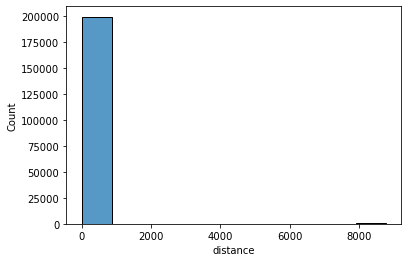

In [25]:
sns.histplot(df.distance, bins=10)

In [26]:
df[df.distance>100].head(20)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,season,distance
346,15.5,2015-03-05 19:15:07+00:00,0.000000,0.000000,-73.979805,40.786030,1,2015,3,5,19,Thursday,spring,8666.723616
1067,52.0,2014-02-02 22:27:00+00:00,-73.781095,40.645015,0.000000,0.000000,1,2014,2,2,22,Sunday,winter,8647.355924
1526,2.5,2014-05-12 12:00:15+00:00,-74.001849,40.715156,0.000000,0.000000,3,2014,5,12,12,Monday,spring,8667.126133
1945,7.0,2013-02-10 16:18:00+00:00,-0.131667,40.757063,-73.991593,40.749953,1,2013,2,10,16,Sunday,winter,6036.406419
2167,5.7,2012-07-21 12:16:00+00:00,-1.216667,40.748597,-74.004822,40.734670,1,2012,7,21,12,Saturday,summer,5956.148468
2547,10.1,2011-09-20 21:08:00+00:00,0.000000,0.000000,-73.953210,40.803528,2,2011,9,20,21,Tuesday,autumn,8664.870047
3045,15.0,2013-03-26 02:25:17+00:00,0.000000,0.000000,-73.843777,40.739255,1,2013,3,26,2,Tuesday,spring,8654.483049
3436,6.9,2012-02-20 00:19:27+00:00,0.000000,0.000000,-73.975224,40.761041,1,2012,2,20,0,Monday,winter,8665.839086
3445,11.5,2013-01-16 22:13:00+00:00,0.000000,40.767907,-73.996505,40.727322,1,2013,1,16,22,Weadnesday,winter,6047.336831
3450,13.3,2012-04-05 21:32:00+00:00,-0.083332,40.737230,0.000000,0.000000,1,2012,4,5,21,Thursday,spring,4511.400204


Скорее всего эти сбои связаны с тем, что одна из пар координат была зафиксирована некорректно. 
Будем считать, что поездки длиной более 100км - это строки с ошибочными данными. 

In [27]:
df[df.distance>100].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459 entries, 346 to 199641
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   fare_amount        459 non-null    float64            
 1   pickup_datetime    459 non-null    datetime64[ns, UTC]
 2   pickup_longitude   459 non-null    float64            
 3   pickup_latitude    459 non-null    float64            
 4   dropoff_longitude  459 non-null    float64            
 5   dropoff_latitude   459 non-null    float64            
 6   passenger_count    459 non-null    int64              
 7   year               459 non-null    int64              
 8   month              459 non-null    int64              
 9   day                459 non-null    int64              
 10  hour               459 non-null    int64              
 11  weekday            459 non-null    object             
 12  season             459 non-null    object    

In [28]:
df = df.drop(df[df.distance>100].index)

In [29]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance
count,199510.000000,199510.000000,199510.000000,199510.000000,199510.000000,199510.000000,199510.000000,199510.000000,199510.000000,199510.000000,199510.000000
mean,11.353895,-72.580201,39.956587,-72.579258,39.956887,1.683580,2011.740354,6.282627,15.706075,13.491078,3.267622
std,9.881287,10.180048,6.006659,10.179947,6.006834,1.306909,1.856448,3.439081,8.687554,6.515842,3.720154
min,0.000000,-75.387785,-74.015515,-75.417737,-74.015750,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,-73.992075,40.734879,-73.991417,40.733908,1.000000,2010.000000,3.000000,8.000000,9.000000,1.213793
50%,8.500000,-73.981842,40.752627,-73.980117,40.753072,1.000000,2012.000000,6.000000,16.000000,14.000000,2.116258
75%,12.500000,-73.967235,40.767178,-73.963752,40.768026,2.000000,2013.000000,9.000000,23.000000,19.000000,3.855080
max,499.000000,40.808425,45.031653,40.831932,45.031598,6.000000,2015.000000,12.000000,31.000000,23.000000,99.232379


Рассмотрим строки, где рассчитанное расстояние равно 0.

In [30]:
df[df.distance==0]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,season,distance
5,4.9,2011-02-12 02:27:09+00:00,-73.969019,40.755910,-73.969019,40.755910,1,2011,2,12,2,Saturday,winter,0.0
7,2.5,2012-12-11 13:52:00+00:00,0.000000,0.000000,0.000000,0.000000,1,2012,12,11,13,Tuesday,winter,0.0
11,8.5,2011-05-23 22:15:00+00:00,0.000000,0.000000,0.000000,0.000000,1,2011,5,23,22,Monday,spring,0.0
48,56.8,2013-01-03 22:24:41+00:00,-73.993498,40.764686,-73.993498,40.764686,1,2013,1,3,22,Thursday,winter,0.0
65,6.0,2014-05-05 19:27:00+00:00,0.000000,0.000000,0.000000,0.000000,1,2014,5,5,19,Monday,spring,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199880,6.5,2014-02-22 06:45:46+00:00,0.000000,0.000000,0.000000,0.000000,1,2014,2,22,6,Saturday,winter,0.0
199883,12.5,2012-09-10 17:39:00+00:00,0.000000,0.000000,0.000000,0.000000,2,2012,9,10,17,Monday,autumn,0.0
199917,4.5,2013-06-24 22:17:43+00:00,-73.793768,40.656939,-73.793768,40.656939,1,2013,6,24,22,Monday,summer,0.0
199932,24.9,2011-03-22 13:59:00+00:00,-73.974618,40.756295,-73.974618,40.756295,5,2011,3,22,13,Tuesday,spring,0.0


Будем считать, что для нашей задачи корректными и пригодными для расчета являются те поездки, в которых машина проделала некоторый путь. Поэтому эти записи тоже удалим. Тем более, среди них есть явно ошибочные строки, в которых координаты не зафиксированы ни в начале, ни в конце поездки

In [31]:
df = df.drop(df[df.distance==0].index)

In [32]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance
count,193878.000000,193878.000000,193878.000000,193878.000000,193878.000000,193878.000000,193878.000000,193878.000000,193878.000000,193878.000000,193878.000000
mean,11.347172,-73.910603,40.688534,-73.909632,40.688842,1.683894,2011.745159,6.281853,15.705253,13.487776,3.362543
std,9.731555,2.685037,2.629322,2.685125,2.629648,1.307104,1.860169,3.440517,8.687815,6.515657,3.731273
min,0.000000,-75.387785,-74.015515,-75.417737,-74.015750,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000084
25%,6.000000,-73.992279,40.736443,-73.991600,40.735312,1.000000,2010.000000,3.000000,8.000000,9.000000,1.280419
50%,8.500000,-73.982130,40.753292,-73.980567,40.753737,1.000000,2012.000000,6.000000,16.000000,14.000000,2.179858
75%,12.500000,-73.968457,40.767532,-73.965512,40.768327,2.000000,2013.000000,9.000000,23.000000,19.000000,3.937065
max,499.000000,40.808425,45.031653,40.831932,45.031598,6.000000,2015.000000,12.000000,31.000000,23.000000,99.232379


In [33]:
# в датасете остались только строки с заполнеными координатами
df.loc[(df['pickup_longitude']==0) | (df['pickup_latitude']==0) | 
      (df['dropoff_longitude']==0) | (df['dropoff_latitude']==0), :]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,season,distance


In [34]:
df.to_csv('uber_cleaned.csv', index=False)

### EDA

#### Распределение целевой переменной

<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

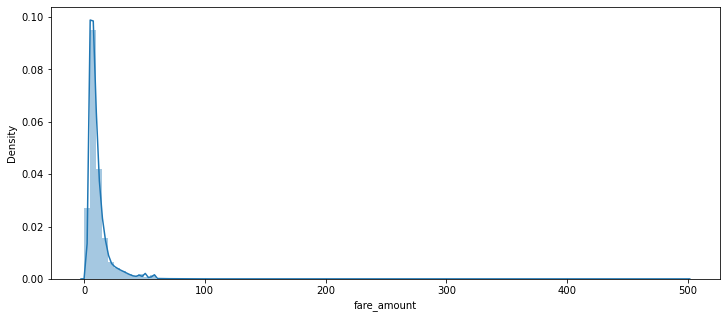

In [22]:
plt.figure(figsize=(12,5))
sns.distplot(df.fare_amount, bins=100)

Распределение с длинным хвостом вправо. Большинство поездок по стоимости не превышают 100 долларов, из них значительная часть стоит около 10$.

#### Средняя стоимость в различные периоды времени

In [30]:
plt.rcParams["figure.figsize"] = (12,5)

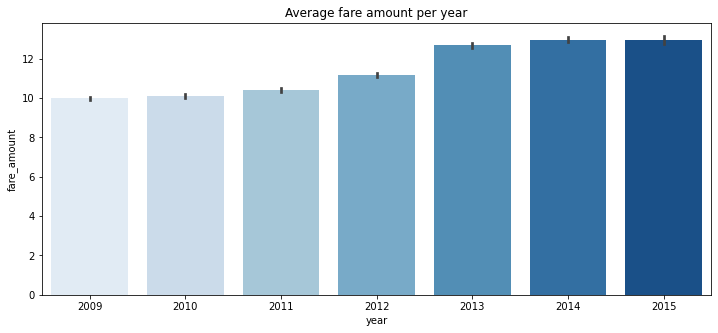

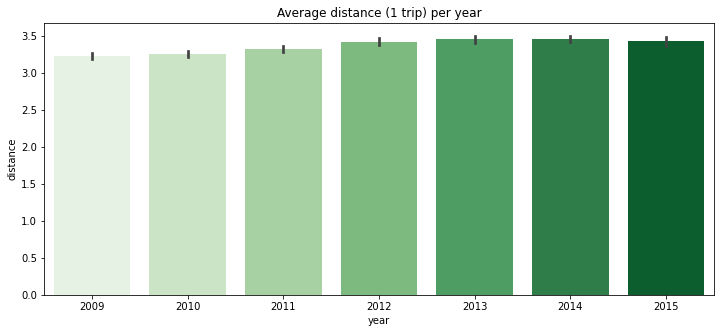

In [39]:
sns.barplot(x='year', y='fare_amount', data=df, palette='Blues')
plt.title('Average fare amount per year')
plt.show()

sns.barplot(x='year', y='distance', data=df, palette='Greens')
plt.title('Average distance (1 trip) per year')
plt.show()


Средняя длина поездки со временем менялась незначительно, но средняя стоимость росла 

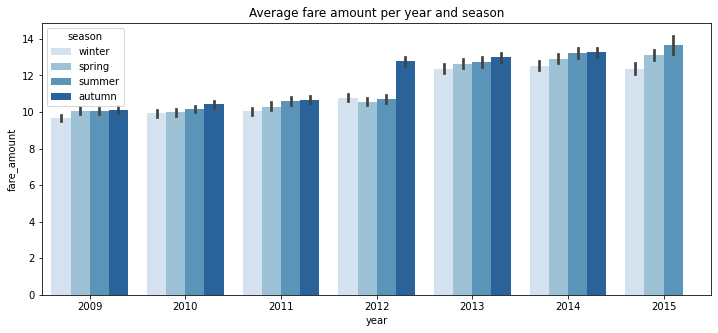

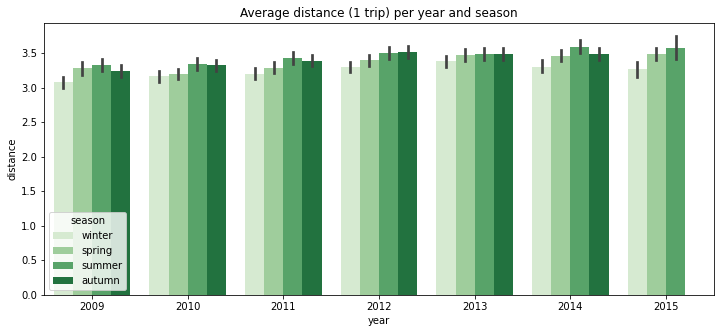

In [56]:
hue_order = ['winter', 'spring', 'summer', 'autumn']

sns.barplot(x='year', y='fare_amount', data=df, hue='season', hue_order=hue_order, palette='Blues')
plt.title('Average fare amount per year and season')
plt.show()

sns.barplot(x='year', y='distance', data=df, hue='season', hue_order=hue_order, palette='Greens')
plt.title('Average distance (1 trip) per year and season')
plt.show()

В зимнее время поездки в среднем чуть короче, чем обычно, и средняя стоимость чуть ниже. Данные за осень 2015 отсутствуют, т.к. датасет хранит данные по июнь 2015 включительно. Зима 2015 присутствует на графиках, т.к. январь 2015 во временной промежуток попадает 

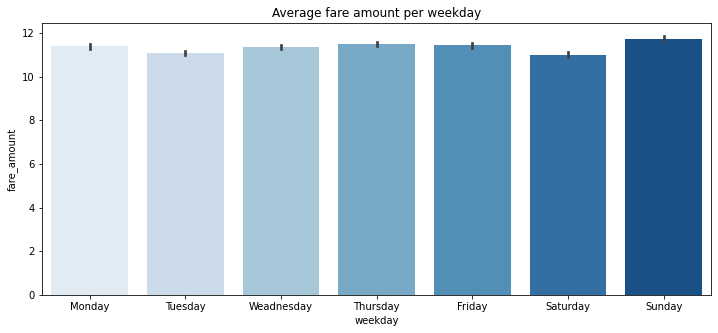

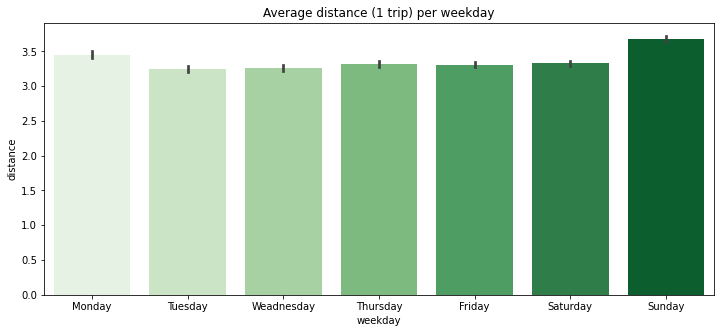

In [45]:
sns.barplot(x='weekday', y='fare_amount', data=df, palette='Blues', order=list(weekday_dict.values()))
plt.title('Average fare amount per weekday')
plt.show()

sns.barplot(x='weekday', y='distance', data=df, palette='Greens', order=list(weekday_dict.values()))
plt.title('Average distance (1 trip) per weekday')
plt.show()

Колебания средней цены и расстояния в пределах недели незначительны.

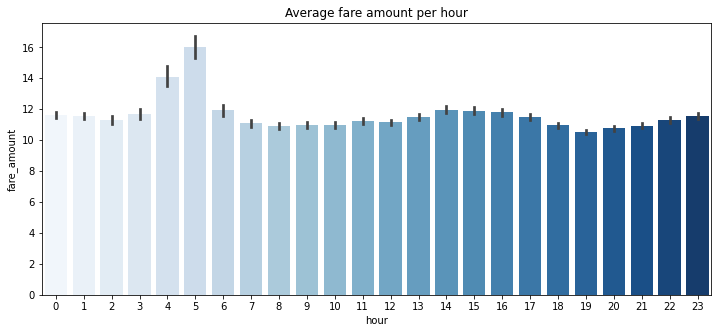

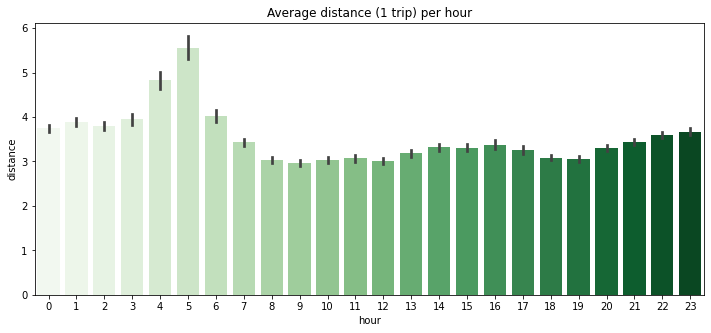

In [47]:
sns.barplot(x='hour', y='fare_amount', data=df, palette='Blues', order=list(range(0, 24)))
plt.title('Average fare amount per hour')
plt.show()

sns.barplot(x='hour', y='distance', data=df, palette='Greens', order=list(range(0, 24)))
plt.title('Average distance (1 trip) per hour')
plt.show()

In [54]:
day_hour = df.groupby(['weekday', 'hour']).count()['distance'].unstack()
day_hour.index = day_hour.index.str.strip()
day_hour = day_hour.reindex(list(weekday_dict.values()))
day_hour

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
weekday,,,,,,,,,,,,,,,,,,,,,
Monday,598,386,264,176,166,229,643,1092,1391,1331,...,1206,1257,1167,1351,1640,1595,1539,1358,1243,961
Tuesday,648,408,255,161,143,264,688,1277,1596,1506,...,1351,1346,1138,1365,1811,1761,1697,1706,1588,1219
Weadnesday,823,500,348,216,192,234,701,1317,1565,1533,...,1417,1321,1073,1388,1748,1837,1715,1770,1582,1277
Thursday,983,546,384,260,206,290,754,1285,1609,1532,...,1390,1334,1077,1352,1743,1919,1827,1810,1713,1581
Friday,1231,825,560,411,306,274,662,1253,1533,1433,...,1400,1328,1139,1364,1755,1979,1748,1707,1764,1747
Saturday,1608,1451,1170,877,591,310,320,460,645,973,...,1363,1432,1264,1418,1630,1760,1622,1646,1717,1805
Sunday,1733,1599,1305,1050,689,291,249,338,492,747,...,1362,1280,1166,1193,1377,1345,1252,1101,1087,898


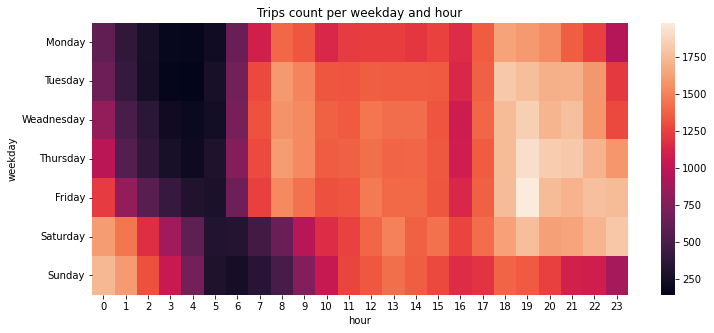

In [56]:
sns.heatmap(day_hour,cmap='rocket')
plt.title('Trips count per weekday and hour')
plt.show()

По визуализации количества поездок в разрезе дня недели и часа суток видно, что:
- наибольшая нагрузка на службы такси - вечер пятницы
- количество поездок в будни увеличивается в начале и в конце рабочего дня
- в выходные график поездок смещается на несколько часов (люди ложаться спать и встают позднее)  

В сочетании с предыдущим графиком распределения цены по часам видим, что временной промежуток, когда стоимость максимальна (4-5 часов утра) совпадает с промежутком, когда количество поездок наимеьшее. Так же на промежутке 18-20 часов видим, что средняя цена падает, а количество поездок, наоборот, растет. 

#### Средняя цена и количество поездок помесячно

In [10]:
df_months = df[['pickup_datetime','fare_amount' ]].copy()

In [12]:
df_months['month_year'] = df_months.pickup_datetime.dt.to_period('M')

In [50]:
df_months_years = df_months.groupby(['month_year']).agg({'fare_amount':'mean', 'pickup_datetime':'count'}).reset_index()
df_months_years = df_months_years.rename({'pickup_datetime':'trip_count', 'fare_amount':'fare_amount_mean'}, axis='columns')
df_months_years.head()

,month_year,fare_amount_mean,trip_count
0,2009-01,9.546407,2477
1,2009-02,9.709425,2244
2,2009-03,10.140992,2642
3,2009-04,10.082695,2508
4,2009-05,10.017656,2594


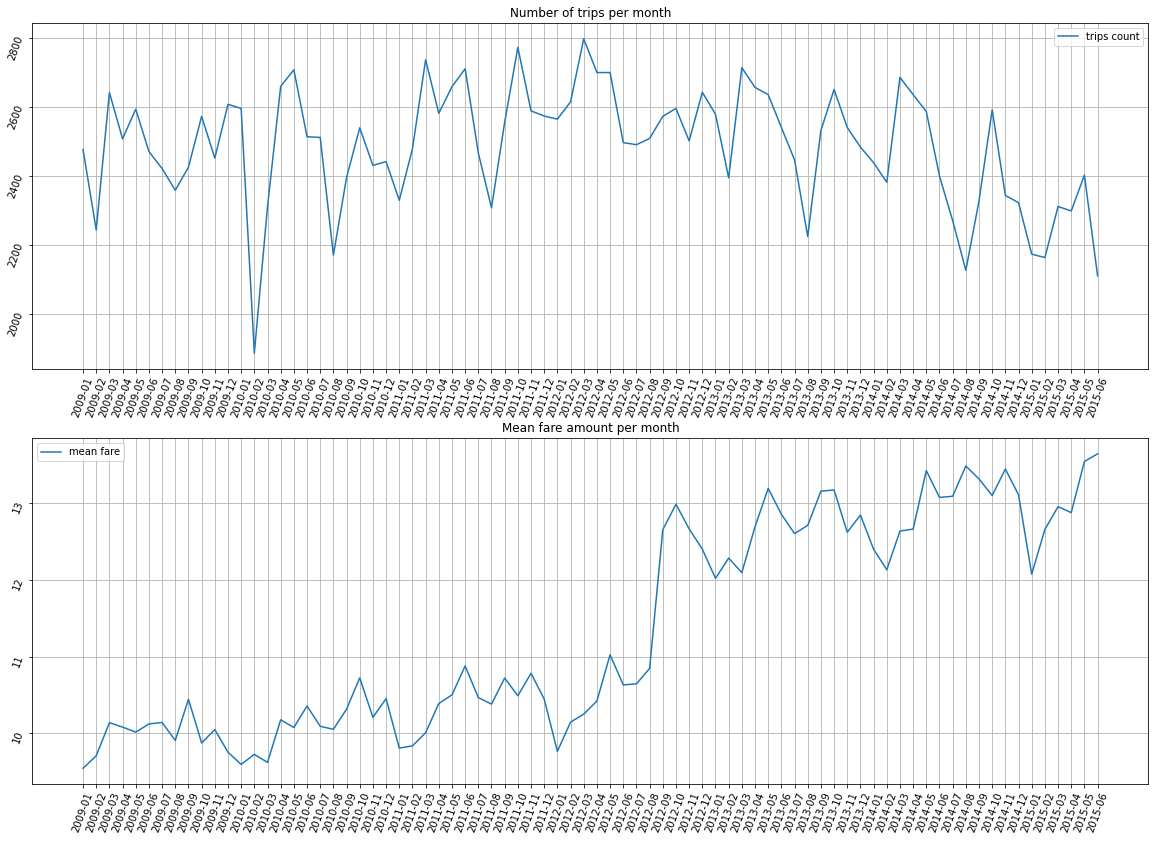

In [55]:
fig, axes = plt.subplots(2, figsize=(20, 14))
axes[0].plot(df_months_years['month_year'].astype(str), df_months_years['trip_count'], label='trips count')
axes[0].tick_params(labelrotation=70)
axes[0].set_title('Number of trips per month')
axes[0].grid()
axes[0].legend()

axes[1].plot(df_months_years['month_year'].astype(str), df_months_years['fare_amount_mean'], label='mean fare')
axes[1].tick_params(labelrotation=70)
axes[1].set_title('Mean fare amount per month')
axes[1].grid()
axes[1].legend()
plt.show()

На графике помесячного количества поездок четкой сезонности не наблюдается, монотонного тренда тоже нет: можно сказать, что до 03-2012 тренд восходящий, а после нисходящий. Однако интересно, что август почти каждого года  (кроме 2012), совпадает с локальным минимумом количества поездок.

График средней стоимости помесячно изменяется более закономерно. Наблюдается восходящий тренд на протяжении всего отрезка времени, и есть сезонное понижение стоимости в начале каждого года (январь, февраль)

Исходя из графиков можно сделать вывод, что временной фактор влияет на ценообразование, поэтому надо будет его надо будет учитывать помимо расстояния при построении моделей

<AxesSubplot:>

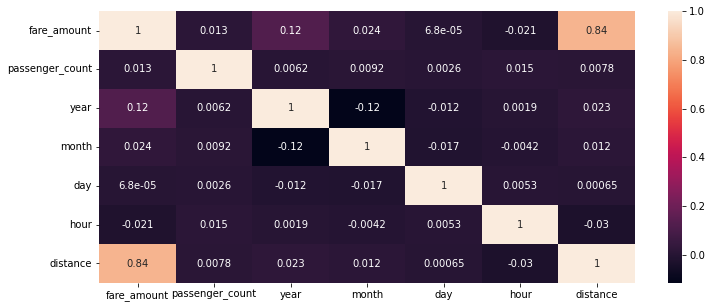

In [68]:
sns.heatmap(df.drop(['pickup_latitude', 'dropoff_latitude', 'pickup_longitude', 'dropoff_longitude'], axis=1).corr(), annot=True)

Хотя если смотреть на корреляцию, то наибольший вклад в целевую переменную ожидаемо вносит расстояние поездки

### Encoding categorical features

In [69]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,season,distance,weekday
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,spring,1.681111,Thursday
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,summer,2.454363,Friday
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,summer,5.039603,Monday
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,summer,1.661442,Friday
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,summer,4.483730,Thursday


In [74]:
df_upd = df.copy()

In [75]:
df_upd = df_upd.drop(['pickup_latitude', 
                  'dropoff_latitude', 
                  'pickup_longitude', 
                  'dropoff_longitude', 
                  'pickup_datetime', 
                  'month','day'], axis=1)

In [76]:
for var in ['season', 'weekday']:
    dummies = pd.get_dummies(df_upd[var])
    dummies = dummies.add_prefix("{}_".format(var))
    df_upd.drop(var, axis=1, inplace=True)
    df_upd = df_upd.join(dummies)

In [77]:
df_upd.head()

,fare_amount,passenger_count,year,hour,distance,season_autumn,season_spring,season_summer,season_winter,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Weadnesday
0,7.5,1,2015,19,1.681111,0,1,0,0,0,0,0,0,1,0,0
1,7.7,1,2009,20,2.454363,0,0,1,0,1,0,0,0,0,0,0
2,12.9,1,2009,21,5.039603,0,0,1,0,0,1,0,0,0,0,0
3,5.3,3,2009,8,1.661442,0,0,1,0,1,0,0,0,0,0,0
4,16.0,5,2014,17,4.483730,0,0,1,0,0,0,0,0,1,0,0


### Normalizing and splitting data on train/test

In [87]:
X = df_upd.drop('fare_amount', axis=1)
Y = df_upd[['fare_amount']]

In [88]:
columns=X.columns

In [89]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=columns)


In [92]:
x_train, x_test, y_train,  y_test = train_test_split(X, Y, test_size=0.25, random_state=146)

### Linear regression

In [93]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [94]:
y_pred = lr.predict(x_test)

In [99]:
results_dict = {}

In [97]:
def print_reg_score(y_pred, y_test, model_name):
    print(model_name)
    print(f'R2-score = {r2_score(y_pred, y_test)}')
    print(f'MSE = {mean_squared_error(y_pred, y_test)}')
    results_dict.update({model_name:[r2_score(y_pred, y_test), mean_squared_error(y_pred, y_test)]})


In [100]:
print_reg_score(y_pred, y_test, "Linear regression")

Linear regression
R2-score = 0.5287789218938508
MSE = 32.8336609324578


### Other models

In [102]:
models = {
    'Ridge': Ridge(), 
    'Lasso': Lasso(), 
    'SVR': SVR(), 
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'SGD Regressor': SGDRegressor()
    
}

In [103]:
for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print_reg_score(y_pred, y_test, model_name)
    print()
    

Ridge
R2-score = 0.5287269015744663
MSE = 32.8332759945935

Lasso
R2-score = 0.34711075494265
MSE = 34.6192202654279

SVR
R2-score = 0.598275512822499
MSE = 27.99107541160098

Decision Tree
R2-score = 0.5535440765416964
MSE = 42.84877807716113

Random Forest
R2-score = 0.6827090423410052
MSE = 24.78613348158288

SGD Regressor
R2-score = 0.5731820565913794
MSE = 33.26986241952245



Наилучший результат у Random Forest Regressor. Попробуем его улучшить за счет подбора гиперпараметров.

### Random Forest model tuning

In [104]:
params = {
 'max_depth': [3, 5, 7, 10, 15],
 'min_samples_leaf': range(2, 9),
 'min_samples_split': range(2, 9),
 'n_estimators': [50, 100, 200, 500]
}

Вначале использую более быстрый RandomizedSearch подбор гиперпараметров, после него GridSearch со значениями, близкими к наилучшему результату RandomizedSearch

In [112]:
rfr = RandomForestRegressor()
random_rfr = RandomizedSearchCV(rfr, param_distributions=params, cv=5, scoring='neg_mean_squared_error', random_state=146)

In [113]:
random_rfr.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [3, 5, 7, 10, 15],
                                        'min_samples_leaf': range(2, 9),
                                        'min_samples_split': range(2, 9),
                                        'n_estimators': [50, 100, 200, 500]},
                   random_state=146, scoring='neg_mean_squared_error')

In [114]:
random_rfr.best_params_

{'n_estimators': 500,
 'min_samples_split': 4,
 'min_samples_leaf': 6,
 'max_depth': 10}

In [116]:
y_pred = random_rfr.best_estimator_.predict(x_test)

In [117]:
print_reg_score(y_pred, y_test, 'RForest randomized parameter tuning')

RForest randomized parameter tuning
R2-score = 0.6936795216711167
MSE = 23.190108223989913


In [121]:
params_for_grid = {
 'max_depth': [10],
 'min_samples_leaf': [5, 6, 7],
 'min_samples_split': [3, 4, 5],
 'n_estimators': [500],
 'max_features': ['auto', 'sqrt']
}

In [127]:
grid_rfr = GridSearchCV(rfr, param_grid=params_for_grid, 
                        cv=5, 
                        scoring='neg_mean_squared_error', 
                        verbose=True, 
                        n_jobs=-1)

In [128]:
grid_rfr.fit(x_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10], 'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [5, 6, 7],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [500]},
             scoring='neg_mean_squared_error', verbose=True)

In [129]:
grid_rfr.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 500}

In [130]:
y_pred = grid_rfr.best_estimator_.predict(x_test)

In [131]:
print_reg_score(y_pred, y_test, 'RForest GridSearch parameter tuning')

RForest GridSearch parameter tuning
R2-score = 0.6933057173961115
MSE = 23.24695101430972


#### Feature importance

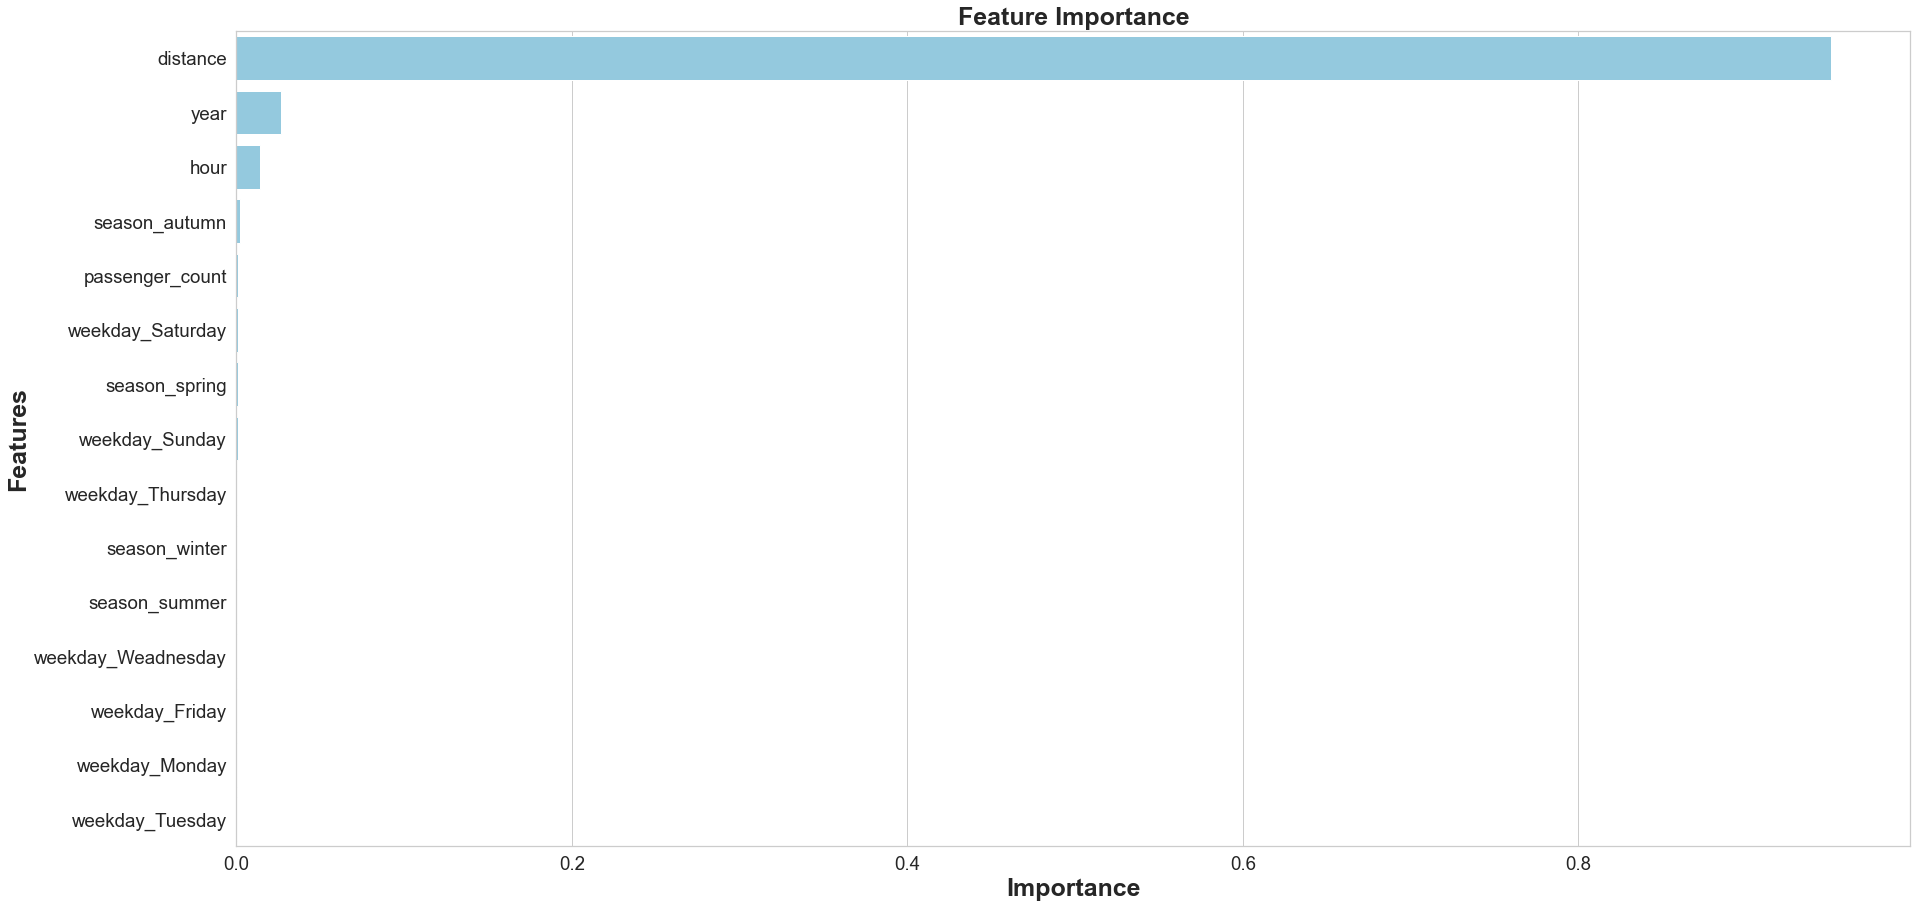

None

,Features,Gini-Importance
0,distance,0.950482
1,year,0.026789
2,hour,0.014076
3,season_autumn,0.002132
4,passenger_count,0.001185
5,weekday_Saturday,0.000805
6,season_spring,0.000694
7,weekday_Sunday,0.000687
8,weekday_Thursday,0.000571
9,season_winter,0.000538


In [132]:
rf_best = grid_rfr.best_estimator_
feats = {}

for feature, importance in zip(X.columns, rf_best.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

### Ensembling. Stacking

In [134]:
stregr = StackingRegressor(
    [
        ('rdg', Ridge()),
        ('dr', DecisionTreeRegressor()),
        ('lr', LinearRegression())
    ],
SVR(kernel='linear'))

In [135]:
stregr.fit(x_train, y_train)

StackingRegressor(estimators=[('rdg', Ridge()), ('dr', DecisionTreeRegressor()),
                              ('lr', LinearRegression())],
                  final_estimator=SVR(kernel='linear'))

In [136]:
y_pred = stregr.predict(x_test)

In [137]:
print_reg_score(y_pred, y_test, 'Stacking')

Stacking
R2-score = 0.5629244741867856
MSE = 31.14666730099411


### Boosting

In [140]:
gb_reg = GradientBoostingRegressor(random_state=0)

In [141]:
gb_reg.fit(x_train, y_train)

GradientBoostingRegressor(random_state=0)

In [142]:
y_pred = gb_reg.predict(x_test)

In [143]:
print_reg_score(y_pred, y_test, 'Gradient boosting')

Gradient boosting
R2-score = 0.68519473437599
MSE = 23.513723522124597


In [150]:
xgb_reg = XGBRegressor()

In [151]:
xgb_reg.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [152]:
y_pred = xgb_reg.predict(x_test)

In [153]:
print_reg_score(y_pred, y_test, 'XGBoost')

XGBoost
R2-score = 0.6874118886314187
MSE = 24.17124862950875


#### tuning xgb 

In [154]:
# параметры, отличные от дефолтных значений
params_xgb = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [4, 7],
    'n_estimators': [200, 500],
    'colsample_bytree': [0.3, 0.7]
}

In [155]:
grid_xgb = GridSearchCV(xgb_reg, param_grid=params_xgb, 
                        cv=5, 
                        scoring='neg_mean_squared_error', 
                        verbose=True, 
                        n_jobs=-1)

In [156]:
grid_xgb.fit(x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1,
                                    enable_categorical=False, gamma=0,
                                    gpu_id=-1, importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=12,
                                    num_parallel_tree=1, predictor='auto',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', val

In [157]:
xgb_best = grid_xgb.best_estimator_

In [158]:
y_pred = xgb_best.predict(x_test)

In [159]:
print_reg_score(y_pred, y_test, 'XGBoost tuned')

XGBoost tuned
R2-score = 0.6905370444751271
MSE = 23.46640472812594


In [236]:
max(y_test.fare_amount)

499.0

### Results

In [170]:
res_df = pd.DataFrame(results_dict).T.rename({0:'R2', 1:'MSE'}, axis=1)
res_df = res_df.sort_values(['R2'], ascending=False)
res_df

,R2,MSE
RForest randomized parameter tuning,0.693680,23.190108
RForest GridSearch parameter tuning,0.693306,23.246951
XGBoost tuned,0.690537,23.466405
XGBoost,0.687412,24.171249
Gradient boosting,0.685195,23.513724
Random Forest,0.682709,24.786133
SVR,0.598276,27.991075
SGD Regressor,0.573182,33.269862
Stacking,0.562924,31.146667
Decision Tree,0.553544,42.848778


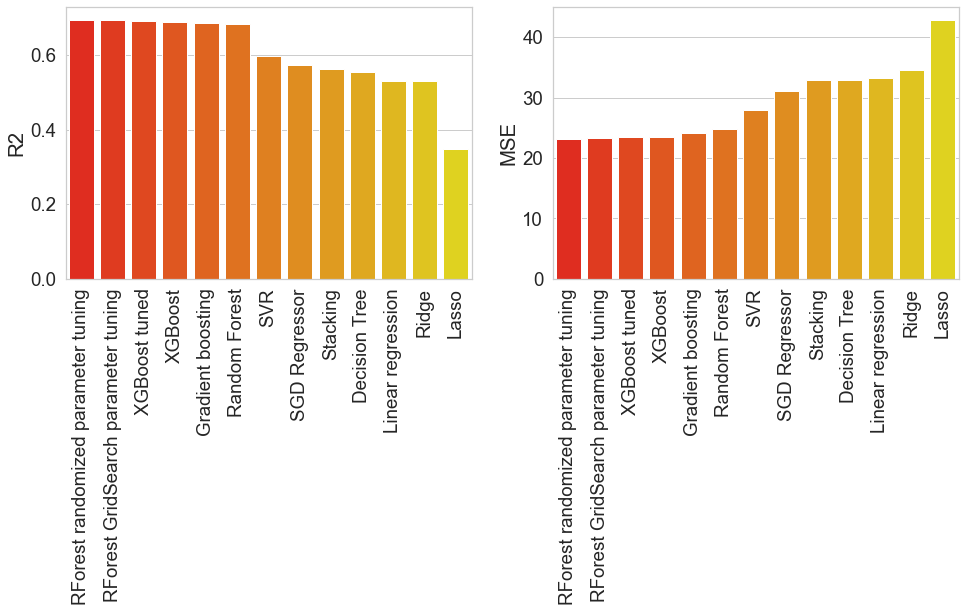

In [225]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5)) 
sns.barplot(x=res_df.index, y='R2', data=res_df, palette='autumn', ax=axes[0])
sns.barplot(x=res_df.index, y='MSE', data=res_df.sort_values(['MSE']), palette='autumn', ax=axes[1])
axes[0].set_xticklabels(res_df.index, rotation=90)
axes[1].set_xticklabels(res_df.index, rotation=90)
plt.show()

Наилучший результат у Random Forest и XGBoost с подобранными гиперпараметрами